<a href="https://colab.research.google.com/github/chillukamaripranaya143/Alzheimer_mini/blob/main/modified(hybrid)(SE-RESNET%2BVGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet

# Upload your Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json from your Kaggle account

# Setup Kaggle API credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ashrafulhossenakash/alzheimer-disease-dataset

# Unzip dataset
!unzip -q alzheimer-disease-dataset.zip -d /content/
!ls /content/Dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ashrafulhossenakash/alzheimer-disease-dataset
License(s): CC0-1.0
 85% 294M/346M [00:00<00:00, 534MB/s]
100% 346M/346M [00:00<00:00, 570MB/s]
ls: cannot access '/content/Dataset': No such file or directory


In [10]:
# Requirements: tensorflow>=2.10, sklearn, matplotlib, seaborn
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input, models
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, applications, regularizers

In [3]:
base_dir = "/content/Alzheimer_Dataset_V2"   # change if needed
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

In [4]:
# ======================
# 1. DATASET SETUP
# ======================

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Detected Classes:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)



Found 23788 files belonging to 4 classes.
Found 5097 files belonging to 4 classes.
Found 5099 files belonging to 4 classes.
Detected Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [5]:
# ======================
# 1. STRONG AUGMENTATION
# ======================
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

In [6]:
# ======================
# 2. SE BLOCK
# ======================
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    x = layers.Multiply()([input_tensor, se])
    return x


In [7]:
# ======================
# 3. SE-ResNet50 FEATURE EXTRACTOR
# ======================
def se_resnet50(input_shape=(224, 224, 3)):
    base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze last few layers for fine-tuning
    for layer in base.layers[:-20]:
        layer.trainable = False

    x = base.output
    x = squeeze_excite_block(x)
    x = layers.GlobalAveragePooling2D()(x)

    return models.Model(inputs=base.input, outputs=x, name="SE_ResNet50_FeatureExtractor")


In [12]:
# ======================
# 4. IMPORT PRETRAINED VGG16 CLASSIFIER (TOP)
# ======================
def pretrained_vgg_classifier(input_tensor, num_classes):
    # Load VGG16 with ImageNet weights
    vgg = applications.VGG16(weights='imagenet', include_top=True)

    # Extract the fully connected classifier part
    vgg_top = models.Sequential(vgg.layers[-3:], name="VGG16_Classifier")  # FC1, FC2, Predictions

    # Remove the last classification layer (1000 classes)
    vgg_top.pop()

    # Rebuild classifier for our classes (Alzheimer stages)
    x = layers.Dense(4096, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(input_tensor)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return output

In [13]:
# ======================
# 5. COMBINE HYBRID MODEL
# ======================
input_shape = (224, 224, 3)
num_classes = len(class_names)

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = applications.resnet.preprocess_input(x)

# Feature extractor
se_resnet = se_resnet50(input_shape)
features = se_resnet(x)

# Pretrained VGG classifier
outputs = pretrained_vgg_classifier(features, num_classes)

# Build the hybrid
model = models.Model(inputs, outputs, name="SE_ResNet50_VGG16_Hybrid")

In [14]:
# ======================
# 5. COMBINE HYBRID MODEL
# ======================
input_shape = (224, 224, 3)
num_classes = len(class_names)

inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = applications.resnet.preprocess_input(x)

# Feature extractor
se_resnet = se_resnet50(input_shape)
features = se_resnet(x)

# Pretrained VGG classifier
outputs = pretrained_vgg_classifier(features, num_classes)

# Build the hybrid
model = models.Model(inputs, outputs, name="SE_ResNet50_VGG16_Hybrid")

In [15]:
# ======================
# 6. COMPILE
# ======================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "SE_ResNet50_VGG16_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 224, 224)  │          0 │ sequential[3][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 224, 224)  │          0 │ sequential[3][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 224, 224)  │          0 │ sequential[3][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 224, 224,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 224, 224,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SE_ResNet50_Featur… │ (None, 2048)      │ 24,114,176 │ add_2[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 4096)      │  8,392,704 │ SE_ResNet50_Feat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 4096)      │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 4096)      │ 16,781,312 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 4096)      │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 4)         │     16,388 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,304,580 (188.08 MB)

 Trainable params: 34,648,196 (132.17 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [16]:

# ======================
# 7. CALLBACKS
# ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3),
    ModelCheckpoint('best_seresnet_vgg16_hybrid.keras', monitor='val_accuracy', save_best_only=True)
]



In [17]:
# ======================
# 8. TRAIN
# ======================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 183s 221ms/step - accuracy: 0.5223 - loss: 1.5806 - val_accuracy: 0.5637 - val_loss: 1.2919 - learning_rate: 3.0000e-04
Epoch 2/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 190s 215ms/step - accuracy: 0.6586 - loss: 1.0227 - val_accuracy: 0.5890 - val_loss: 1.1312 - learning_rate: 3.0000e-04
Epoch 3/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 163s 219ms/step - accuracy: 0.6952 - loss: 0.8256 - val_accuracy: 0.6565 - val_loss: 0.8662 - learning_rate: 3.0000e-04
Epoch 4/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 203s 220ms/step - accuracy: 0.7282 - loss: 0.7031 - val_accuracy: 0.7563 - val_loss: 0.6074 - learning_rate: 3.0000e-04
Epoch 5/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 168s 225ms/step - accuracy: 0.7574 - loss: 0.6202 - val_accuracy: 0.7787 - val_loss: 0.5391 - learning_rate: 3.0000e-04
Epoch 6/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 168s 225ms/step - accuracy: 0.7719 - loss: 0.5606 - val_accuracy: 0.7958 - val_loss: 0.5238 - learning_rate: 3.0000e-04
Epoch 7/20
744/744 ━━━━━━━━━━━━━━━━━━━━ 

In [18]:
# ---------- EVALUATION ----------
print("Evaluating on test set...")
results = model.evaluate(test_ds)
print("Test loss, Test accuracy:", results)

Evaluating on test set...
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9739 - loss: 0.0919
Test loss, Test accuracy: [0.1894947588443756, 0.9360659122467041]


160/160 ━━━━━━━━━━━━━━━━━━━━ 24s 136ms/step
                  precision    recall  f1-score   support

    MildDemented       0.96      0.98      0.97      1344
ModerateDemented       1.00      1.00      1.00       971
     NonDemented       0.88      0.93      0.91      1440
VeryMildDemented       0.92      0.85      0.89      1344

        accuracy                           0.94      5099
       macro avg       0.94      0.94      0.94      5099
    weighted avg       0.94      0.94      0.94      5099



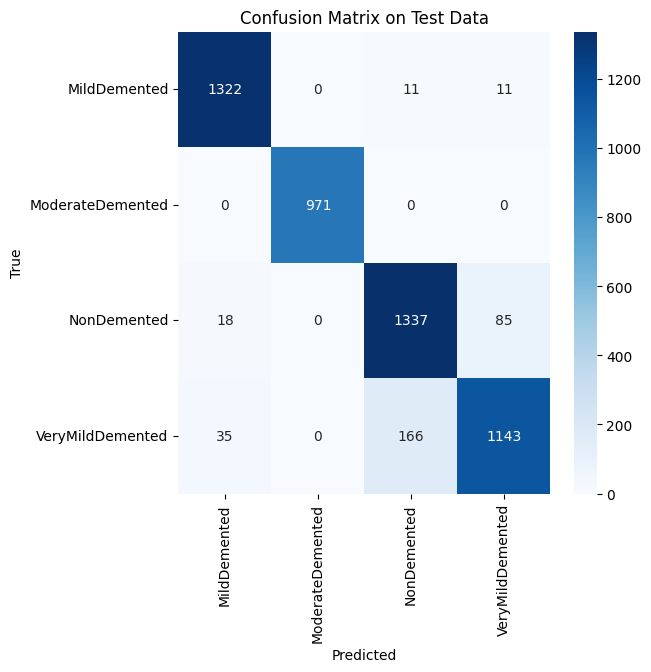

In [19]:
# Get true & predicted labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
# Report
print(classification_report(y_true, y_pred, target_names=class_names))
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data")
plt.show()

In [21]:
model.save("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


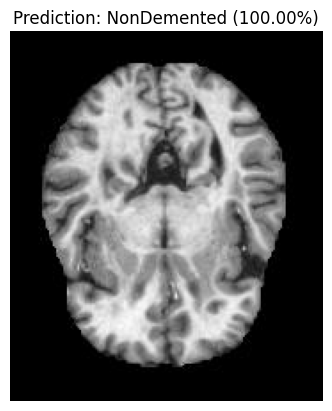

In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load saved model
model = tf.keras.models.load_model("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

# Class names (make sure they match your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Function to test one external image
def test_external_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

# Example: test with any MRI image file path
test_external_image("/content/nonDem0.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


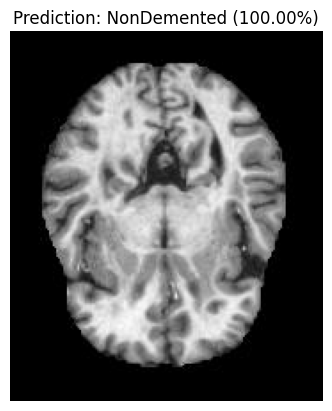

In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load saved model
model = tf.keras.models.load_model("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

# Class names (make sure they match your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Function to test one external image
def test_external_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

# Example: test with any MRI image file path
test_external_image("/content/nonDem0.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


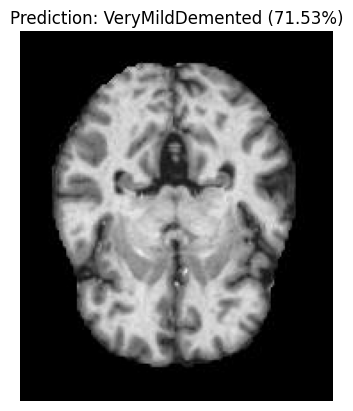

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load saved model
model = tf.keras.models.load_model("SE_ResNet50_VGG_Alzheimer_Model(final).keras")

# Class names (make sure they match your dataset)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Function to test one external image
def test_external_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)

    predictions = model.predict(img_array)
    pred_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0]) * 100

    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.axis('off')
    plt.title(f"Prediction: {pred_class} ({confidence:.2f}%)")
    plt.show()

# Example: test with any MRI image file path
test_external_image("/content/verymildDem0.jpg")